Section 0 – Setup & Data Engineering

0.1 Install & imports

In [ ]:
!pip install numpy scipy pandas matplotlib tqdm pyulog


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyulog import ULog


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 4.2 MB/s eta 0:00:00


0.2 Load your PX4 log

Upload .ulg in the Colab

In [ ]:
!git clone https://github.com/arplaboratory/data-driven-system-identification.git
%cd data-driven-system-identification
!ls


Cloning into 'data-driven-system-identification'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 79 (delta 24), reused 17 (delta 17), pack-reused 48 (from 1)
Receiving objects: 100% (79/79), 24.63 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/data-driven-system-identification
build.sh		index.html			 prejs.js
CMakeLists.txt		large_flights_thrust_timeframes  range_picker_chart.js
download_cfusdlog.sh	LICENSE				 README.MD
excitation_metrics.js	load_ulg.py			 src
fetch_with_progress.js	logs_crazyflie			 sysid.ipynb
figures			logs_large
index.css		pick_ranges.js


In [ ]:
import os
os.listdir()


['src',
 'CMakeLists.txt',
 'excitation_metrics.js',
 '.git',
 'index.css',
 'logs_large',
 'LICENSE',
 '.gitmodules',
 'index.html',
 '.gitignore',
 'download_cfusdlog.sh',
 'sysid.ipynb',
 'figures',
 'pick_ranges.js',
 'README.MD',
 'fetch_with_progress.js',
 'build.sh',
 'prejs.js',
 'logs_crazyflie',
 'load_ulg.py',
 'range_picker_chart.js',
 'large_flights_thrust_timeframes']

In [ ]:
import os
from pyulog import ULog

log_dir = "logs_large"
print("Files in", log_dir, ":", os.listdir(log_dir))

log_path = os.path.join(log_dir, os.listdir(log_dir)[0])
print("Using log:", log_path)

ulog = ULog(log_path)
print("Available topics:")
for m in ulog.data_list:
    print(" -", m.name)

Files in logs_large : ['log_63_2024-1-8-16-37-54.ulg', 'log_65_2024-1-8-16-40-52.ulg', 'log_64_2024-1-8-16-39-44.ulg', 'log_66_2024-1-8-16-42-48.ulg']
Using log: logs_large/log_63_2024-1-8-16-37-54.ulg
Available topics:
 - actuator_motors
 - actuator_motors_mux
 - actuator_motors_rl_tools
 - event
 - rl_tools_multiplexer_status
 - rl_tools_policy_status
 - vehicle_acceleration
 - vehicle_angular_velocity
 - vehicle_attitude
 - vehicle_local_position


0.3 Converting a ulog topic to a DataFrame

In [ ]:
import numpy as np
import pandas as pd

def ulog_topic_to_df(ulog, topic_name):
    """Convert one ULog topic into a pandas DataFrame with time in seconds."""
    matching = [m for m in ulog.data_list if m.name == topic_name]
    if not matching:
        raise ValueError(f"Topic {topic_name} not found in log")
    m = matching[0]
    df = pd.DataFrame(m.data)
    if 'timestamp' not in df.columns:
        raise ValueError(f"'timestamp' column missing in topic {topic_name}")
    df = df.sort_values('timestamp')
    df['t'] = (df['timestamp'] - df['timestamp'].iloc[0]) * 1e-6  # µs → s
    return df


0.4 Extract and align the three key signals

In [ ]:
rate_topic   = "vehicle_angular_velocity"
accel_topic  = "vehicle_acceleration"
motors_topic = "actuator_motors"

df_rate   = ulog_topic_to_df(ulog, rate_topic)
df_accel  = ulog_topic_to_df(ulog, accel_topic)
df_motors = ulog_topic_to_df(ulog, motors_topic)

print("rate cols:", df_rate.columns.tolist())
print("accel cols:", df_accel.columns.tolist())
print("motors cols:", df_motors.columns.tolist())

df_rate.head(), df_accel.head(), df_motors.head()


rate cols: ['timestamp', 'timestamp_sample', 'xyz[0]', 'xyz[1]', 'xyz[2]', 'xyz_derivative[0]', 'xyz_derivative[1]', 'xyz_derivative[2]', 't']
accel cols: ['timestamp', 'timestamp_sample', 'xyz[0]', 'xyz[1]', 'xyz[2]', 't']
motors cols: ['timestamp', 'timestamp_sample', 'control[0]', 'control[1]', 'control[2]', 'control[3]', 'control[4]', 'control[5]', 'control[6]', 'control[7]', 'control[8]', 'control[9]', 'control[10]', 'control[11]', 'reversible_flags', 't']


(   timestamp  timestamp_sample    xyz[0]    xyz[1]    xyz[2]  \
 0   67942044          67941979  0.000716  0.007739 -0.006489   
 1   67943545          67943478 -0.001243  0.002554  0.001206   
 2   67945039          67944977 -0.002692 -0.006450  0.008386   
 3   67948038          67947975 -0.002062 -0.013444  0.013082   
 4   67949537          67949473 -0.001599 -0.008180  0.009345   
 
    xyz_derivative[0]  xyz_derivative[1]  xyz_derivative[2]         t  
 0           0.076941           0.787571          -1.435892  0.000000  
 1          -0.259317          -0.232000           0.125379  0.001501  
 2          -0.425716          -1.602308           1.219305  0.002995  
 3          -0.185713          -1.751599           1.249955  0.005994  
 4          -0.069686          -0.492107           0.361984  0.007493  ,
    timestamp  timestamp_sample    xyz[0]    xyz[1]    xyz[2]         t
 0   67939468          67939379  0.021905  0.001731 -9.673774  0.000000
 1   67944481          67944391

In [ ]:
# 1) start from angular rates (base timeline)
df_rate_small = df_rate[["t", "xyz[0]", "xyz[1]", "xyz[2]"]].rename(
    columns={"xyz[0]": "p", "xyz[1]": "q", "xyz[2]": "r"}
)

# 2) accelerations
df_accel_small = df_accel[["t", "xyz[0]", "xyz[1]", "xyz[2]"]].rename(
    columns={"xyz[0]": "ax", "xyz[1]": "ay", "xyz[2]": "az"}
)

# 3) motor controls (take first 4 motors)
df_motors_small = df_motors[["t", "control[0]", "control[1]", "control[2]", "control[3]"]].rename(
    columns={"control[0]": "u1", "control[1]": "u2",
             "control[2]": "u3", "control[3]": "u4"}
)

# ensure sorted by time
df_rate_small   = df_rate_small.sort_values("t")
df_accel_small  = df_accel_small.sort_values("t")
df_motors_small = df_motors_small.sort_values("t")

# merge with nearest timestamps
df = pd.merge_asof(df_rate_small, df_accel_small, on="t", direction="nearest")
df = pd.merge_asof(df, df_motors_small, on="t", direction="nearest")

df.head()


,t,p,q,r,ax,ay,az,u1,u2,u3,u4
0,0.000000,0.000716,0.007739,-0.006489,0.021905,0.001731,-9.673774,0.075360,0.086954,0.086940,0.070746
1,0.001501,-0.001243,0.002554,0.001206,0.021905,0.001731,-9.673774,0.075547,0.084140,0.092017,0.068296
2,0.002995,-0.002692,-0.006450,0.008386,-0.052886,0.194769,-9.796977,0.077572,0.079889,0.097496,0.065043
3,0.005994,-0.002062,-0.013444,0.013082,-0.052886,0.194769,-9.796977,0.078889,0.077545,0.098422,0.065144
4,0.007493,-0.001599,-0.008180,0.009345,-0.052886,0.194769,-9.796977,0.076803,0.080988,0.094246,0.067963


In [ ]:
df = df.dropna(subset=["u1", "u2", "u3", "u4"]).reset_index(drop=True)
df.head()


,t,p,q,r,ax,ay,az,u1,u2,u3,u4
0,0.000000,0.000716,0.007739,-0.006489,0.021905,0.001731,-9.673774,0.075360,0.086954,0.086940,0.070746
1,0.001501,-0.001243,0.002554,0.001206,0.021905,0.001731,-9.673774,0.075547,0.084140,0.092017,0.068296
2,0.002995,-0.002692,-0.006450,0.008386,-0.052886,0.194769,-9.796977,0.077572,0.079889,0.097496,0.065043
3,0.005994,-0.002062,-0.013444,0.013082,-0.052886,0.194769,-9.796977,0.078889,0.077545,0.098422,0.065144
4,0.007493,-0.001599,-0.008180,0.009345,-0.052886,0.194769,-9.796977,0.076803,0.080988,0.094246,0.067963


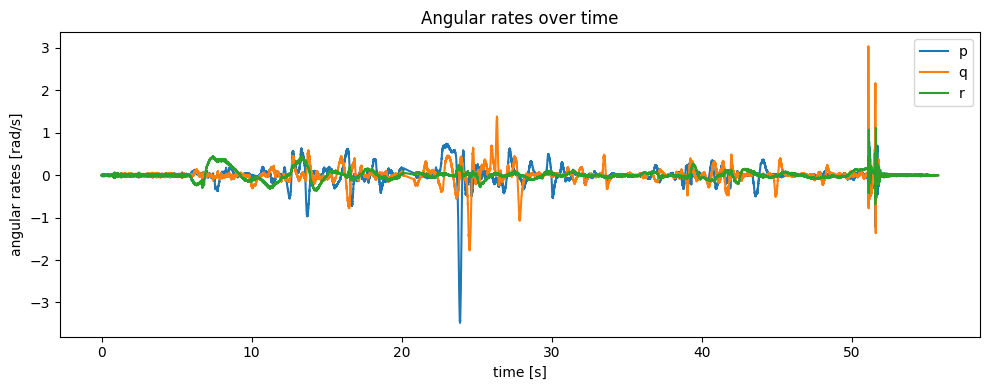

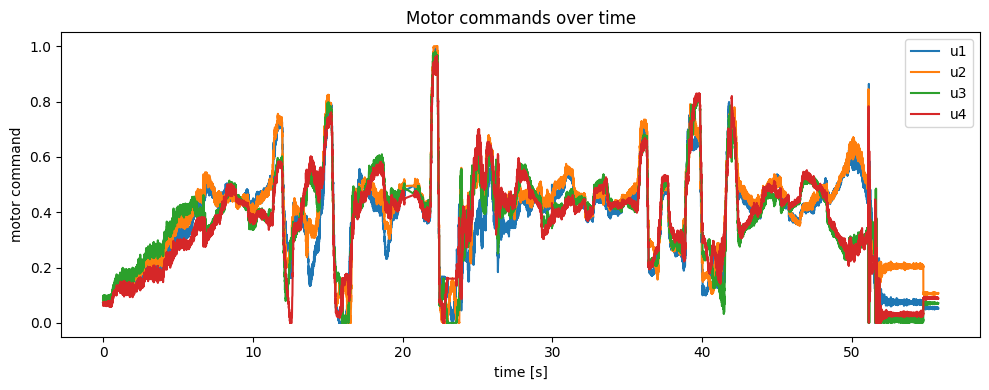

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df["t"], df["p"], label="p")
plt.plot(df["t"], df["q"], label="q")
plt.plot(df["t"], df["r"], label="r")
plt.xlabel("time [s]")
plt.ylabel("angular rates [rad/s]")
plt.legend()
plt.title("Angular rates over time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["t"], df["u1"], label="u1")
plt.plot(df["t"], df["u2"], label="u2")
plt.plot(df["t"], df["u3"], label="u3")
plt.plot(df["t"], df["u4"], label="u4")
plt.xlabel("time [s]")
plt.ylabel("motor command")
plt.legend()
plt.title("Motor commands over time")
plt.tight_layout()
plt.show()


Section 1 – Build 1-step Markov dataset (X,y) and splits

1.1 Build feature/target arrays

In [ ]:
feature_cols = ["p", "q", "r", "ax", "ay", "az", "u1", "u2", "u3", "u4"]
target_cols  = ["p", "q", "r", "ax", "ay", "az"]

data = df[["t"] + feature_cols + target_cols].dropna().reset_index(drop=True)

# time aligned with x_t / y_t
t_all = data["t"].values

X_all = data[feature_cols].values   # (N, D_in)
y_all = data[target_cols].values    # (N, D_out)

# 1-step pairs: input at t, target at t+1
X = X_all[:-1]
y = y_all[1:]
t_for_X = t_all[:-1]   # time stamps corresponding to X_t

X.shape, y.shape


((27523, 16), (27523, 12))

1.2 Time-respecting train / val / test splits

In [ ]:
N = len(X)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

X_train = X[:n_train]
y_train = y[:n_train]

X_val   = X[n_train:n_train + n_val]
y_val   = y[n_train:n_train + n_val]

X_test  = X[n_train + n_val:]
y_test  = y[n_train + n_val:]

t_train = t_for_X[:n_train]
t_val   = t_for_X[n_train:n_train + n_val]
t_test  = t_for_X[n_train + n_val:]

N, n_train, n_val, n_test


(27523, 19266, 4128, 4129)

Section 2 – Baseline Ridge + model zoo (Ridge, RF, GB, MLP)

Now we do the core regression comparison (RQ1).

We’ll:

Standardize features inside a pipeline (important for Ridge/MLP).

Use one helper eval_model so all models are evaluated identically.

2.1 Shared helper for RMSE evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def eval_model(name, model,
               X_train, y_train,
               X_val,   y_val,
               X_test,  y_test,
               target_cols):
    """
    Fit model, compute overall and per-channel RMSE on val + test,
    and return a result dict.
    """
    model.fit(X_train, y_train)

    y_val_pred  = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    rmse_val  = np.sqrt(mean_squared_error(y_val,  y_val_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mse_val_ch  = ((y_val  - y_val_pred)**2).mean(axis=0)
    mse_test_ch = ((y_test - y_test_pred)**2).mean(axis=0)
    rmse_val_ch  = np.sqrt(mse_val_ch)
    rmse_test_ch = np.sqrt(mse_test_ch)

    print(f"\n=== {name} ===")
    print("Val RMSE :", rmse_val)
    print("Test RMSE:", rmse_test)
    for col, rv, rt in zip(target_cols, rmse_val_ch, rmse_test_ch):
        print(f"  {col:>3}: Val RMSE = {rv:.4f}, Test RMSE = {rt:.4f}")

    res = {
        "model": name,
        "val_rmse": rmse_val,
        "test_rmse": rmse_test,
    }
    for col, rv, rt in zip(target_cols, rmse_val_ch, rmse_test_ch):
        res[f"val_{col}"]  = rv
        res[f"test_{col}"] = rt
    return res


2.2 Ridge regression (tuned α) – baseline & winner candidate

In [ ]:
from sklearn.linear_model import Ridge

alphas = [1e-3, 1e-2, 1e-1, 1.0, 10.0]

ridge_results = []
for a in alphas:
    model = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a)
    )
    name = f"Ridge(alpha={a})"
    res  = eval_model(name, model,
                      X_train, y_train,
                      X_val,   y_val,
                      X_test,  y_test,
                      target_cols)
    res["alpha"] = a
    ridge_results.append(res)

best_ridge = min(ridge_results, key=lambda d: d["val_rmse"])
best_ridge



=== Ridge(alpha=0.001) ===
Val RMSE : 0.17878768398627765
Test RMSE: 0.9144104841312939
    p: Val RMSE = 0.0109, Test RMSE = 0.0339
    q: Val RMSE = 0.0109, Test RMSE = 0.0339
    r: Val RMSE = 0.0187, Test RMSE = 0.0542
   ax: Val RMSE = 0.0187, Test RMSE = 0.0542
   ay: Val RMSE = 0.0081, Test RMSE = 0.0327
   az: Val RMSE = 0.0081, Test RMSE = 0.0327

=== Ridge(alpha=0.01) ===
Val RMSE : 0.17878764231348845
Test RMSE: 0.914410353763915
    p: Val RMSE = 0.0109, Test RMSE = 0.0339
    q: Val RMSE = 0.0109, Test RMSE = 0.0339
    r: Val RMSE = 0.0187, Test RMSE = 0.0542
   ax: Val RMSE = 0.0187, Test RMSE = 0.0542
   ay: Val RMSE = 0.0081, Test RMSE = 0.0327
   az: Val RMSE = 0.0081, Test RMSE = 0.0327

=== Ridge(alpha=0.1) ===
Val RMSE : 0.1787874026947621
Test RMSE: 0.9144094737836214
    p: Val RMSE = 0.0109, Test RMSE = 0.0339
    q: Val RMSE = 0.0109, Test RMSE = 0.0339
    r: Val RMSE = 0.0187, Test RMSE = 0.0542
   ax: Val RMSE = 0.0187, Test RMSE = 0.0542
   ay: Val RMSE = 

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.36446e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


{'model': 'Ridge(alpha=10.0)',
 'val_rmse': np.float64(0.17875726026515837),
 'test_rmse': np.float64(0.9143437336017168),
 'val_p': np.float32(0.010870834),
 'test_p': np.float32(0.03393333),
 'val_q': np.float32(0.010870834),
 'test_q': np.float32(0.03393333),
 'val_r': np.float32(0.01865996),
 'test_r': np.float32(0.054231163),
 'val_ax': np.float32(0.01865996),
 'test_ax': np.float32(0.054231163),
 'val_ay': np.float32(0.008131686),
 'test_ay': np.float32(0.032655217),
 'val_az': np.float32(0.008131686),
 'test_az': np.float32(0.032655217),
 'alpha': 10.0}

2.3 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = [
    {"n_estimators": 100, "max_depth": None, "min_samples_leaf": 1},
    {"n_estimators": 300, "max_depth": None, "min_samples_leaf": 1},
    {"n_estimators": 200, "max_depth": 10,   "min_samples_leaf": 1},
    {"n_estimators": 200, "max_depth": 20,   "min_samples_leaf": 1},
    {"n_estimators": 200, "max_depth": None, "min_samples_leaf": 5},
]

rf_results = []
for params in rf_param_grid:
    model = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        n_jobs=-1,
        random_state=0,
    )
    name = f"RF(ne={params['n_estimators']}, depth={params['max_depth']}, leaf={params['min_samples_leaf']})"
    res  = eval_model(name, model,
                      X_train, y_train,
                      X_val,   y_val,
                      X_test,  y_test,
                      target_cols)
    res.update(params)
    rf_results.append(res)

best_rf = min(rf_results, key=lambda d: d["val_rmse"])
best_rf



=== RF(ne=100, depth=None, leaf=1) ===
Val RMSE : 0.225146823755976
Test RMSE: 1.4447801421050817
    p: Val RMSE = 0.0915, Test RMSE = 0.0930
    q: Val RMSE = 0.0915, Test RMSE = 0.0930
    r: Val RMSE = 0.1198, Test RMSE = 0.1800
   ax: Val RMSE = 0.1198, Test RMSE = 0.1800
   ay: Val RMSE = 0.0839, Test RMSE = 0.0807
   az: Val RMSE = 0.0839, Test RMSE = 0.0807

=== RF(ne=300, depth=None, leaf=1) ===
Val RMSE : 0.22431632133210785
Test RMSE: 1.444648486089578
    p: Val RMSE = 0.0914, Test RMSE = 0.0930
    q: Val RMSE = 0.0914, Test RMSE = 0.0930
    r: Val RMSE = 0.1176, Test RMSE = 0.1795
   ax: Val RMSE = 0.1176, Test RMSE = 0.1795
   ay: Val RMSE = 0.0833, Test RMSE = 0.0809
   az: Val RMSE = 0.0833, Test RMSE = 0.0809

=== RF(ne=200, depth=10, leaf=1) ===
Val RMSE : 0.22866880705744874
Test RMSE: 1.4450022765724366
    p: Val RMSE = 0.1046, Test RMSE = 0.1017
    q: Val RMSE = 0.1046, Test RMSE = 0.1017
    r: Val RMSE = 0.1268, Test RMSE = 0.1854
   ax: Val RMSE = 0.1268, T

{'model': 'RF(ne=200, depth=20, leaf=1)',
 'val_rmse': np.float64(0.22399587962145678),
 'test_rmse': np.float64(1.444513674168461),
 'val_p': np.float64(0.09057638529616735),
 'test_p': np.float64(0.09273387695120597),
 'val_q': np.float64(0.09057638529616735),
 'test_q': np.float64(0.09273387695120597),
 'val_r': np.float64(0.11648478426071777),
 'test_r': np.float64(0.18003063704827946),
 'val_ax': np.float64(0.11648478426071777),
 'test_ax': np.float64(0.18003063704827946),
 'val_ay': np.float64(0.08398508363758324),
 'test_ay': np.float64(0.08100155508225369),
 'val_az': np.float64(0.08398508363758324),
 'test_az': np.float64(0.08100155508225369),
 'n_estimators': 200,
 'max_depth': 20,
 'min_samples_leaf': 1}

2.4 Gradient Boosting Regressor (wrapped as multi-output)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gb_param_grid = [
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 2},
    {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 2},
    {"n_estimators": 200, "learning_rate": 0.10, "max_depth": 3},
]

gb_results = []
for params in gb_param_grid:
    base = GradientBoostingRegressor(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        random_state=0,
    )
    model = MultiOutputRegressor(base)
    name  = f"GB(ne={params['n_estimators']}, lr={params['learning_rate']}, depth={params['max_depth']})"
    res   = eval_model(name, model,
                       X_train, y_train,
                       X_val,   y_val,
                       X_test,  y_test,
                       target_cols)
    res.update(params)
    gb_results.append(res)

best_gb = min(gb_results, key=lambda d: d["val_rmse"])
best_gb



=== GB(ne=200, lr=0.05, depth=2) ===
Val RMSE : 0.17953376625821188
Test RMSE: 1.3642010425377373
    p: Val RMSE = 0.0115, Test RMSE = 0.0317
    q: Val RMSE = 0.0115, Test RMSE = 0.0317
    r: Val RMSE = 0.0188, Test RMSE = 0.0730
   ax: Val RMSE = 0.0188, Test RMSE = 0.0730
   ay: Val RMSE = 0.0081, Test RMSE = 0.0378
   az: Val RMSE = 0.0081, Test RMSE = 0.0378

=== GB(ne=300, lr=0.05, depth=2) ===
Val RMSE : 0.17971455004646117
Test RMSE: 1.3628272422454346
    p: Val RMSE = 0.0115, Test RMSE = 0.0317
    q: Val RMSE = 0.0115, Test RMSE = 0.0317
    r: Val RMSE = 0.0188, Test RMSE = 0.0727
   ax: Val RMSE = 0.0188, Test RMSE = 0.0727
   ay: Val RMSE = 0.0081, Test RMSE = 0.0377
   az: Val RMSE = 0.0081, Test RMSE = 0.0377

=== GB(ne=200, lr=0.1, depth=3) ===
Val RMSE : 0.17941088313615314
Test RMSE: 1.367622736587766
    p: Val RMSE = 0.0116, Test RMSE = 0.0318
    q: Val RMSE = 0.0116, Test RMSE = 0.0318
    r: Val RMSE = 0.0189, Test RMSE = 0.0740
   ax: Val RMSE = 0.0189, Test

{'model': 'GB(ne=200, lr=0.1, depth=3)',
 'val_rmse': np.float64(0.17941088313615314),
 'test_rmse': np.float64(1.367622736587766),
 'val_p': np.float64(0.011618482456706462),
 'test_p': np.float64(0.0317810551464121),
 'val_q': np.float64(0.011618482456706462),
 'test_q': np.float64(0.0317810551464121),
 'val_r': np.float64(0.01889099030998955),
 'test_r': np.float64(0.07398895118920035),
 'val_ax': np.float64(0.01889099030998955),
 'test_ax': np.float64(0.07398895118920035),
 'val_ay': np.float64(0.008320124960721226),
 'test_ay': np.float64(0.0385801696424787),
 'val_az': np.float64(0.008320124960721226),
 'test_az': np.float64(0.0385801696424787),
 'n_estimators': 200,
 'learning_rate': 0.1,
 'max_depth': 3}

2.5 MLPRegressor (small NN)

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_param_grid = [
    {"hidden_layer_sizes": (64, 64), "alpha": 1e-4},
    {"hidden_layer_sizes": (64, 64), "alpha": 1e-3},
    {"hidden_layer_sizes": (128, 64), "alpha": 1e-4},
]

mlp_results = []
for params in mlp_param_grid:
    model = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            activation="relu",
            alpha=params["alpha"],
            max_iter=2000,
            random_state=0,
        ),
    )
    name = f"MLP{params['hidden_layer_sizes']}_alpha{params['alpha']}"
    res  = eval_model(name, model,
                      X_train, y_train,
                      X_val,   y_val,
                      X_test,  y_test,
                      target_cols)
    res.update(params)
    mlp_results.append(res)

best_mlp = min(mlp_results, key=lambda d: d["val_rmse"])
best_mlp



=== MLP(64, 64)_alpha0.0001 ===
Val RMSE : 0.19089469865416417
Test RMSE: 1.121429339964849
    p: Val RMSE = 0.0362, Test RMSE = 0.2245
    q: Val RMSE = 0.0312, Test RMSE = 0.1877
    r: Val RMSE = 0.0437, Test RMSE = 0.2128
   ax: Val RMSE = 0.0369, Test RMSE = 0.0968
   ay: Val RMSE = 0.0215, Test RMSE = 0.0816
   az: Val RMSE = 0.0283, Test RMSE = 0.1514

=== MLP(64, 64)_alpha0.001 ===
Val RMSE : 0.19293478384969867
Test RMSE: 1.1368114001083023
    p: Val RMSE = 0.0363, Test RMSE = 0.2258
    q: Val RMSE = 0.0317, Test RMSE = 0.1931
    r: Val RMSE = 0.0426, Test RMSE = 0.2356
   ax: Val RMSE = 0.0381, Test RMSE = 0.1082
   ay: Val RMSE = 0.0220, Test RMSE = 0.0821
   az: Val RMSE = 0.0306, Test RMSE = 0.1586

=== MLP(128, 64)_alpha0.0001 ===
Val RMSE : 0.18600907230491318
Test RMSE: 1.5533614134126421
    p: Val RMSE = 0.0355, Test RMSE = 0.2584
    q: Val RMSE = 0.0333, Test RMSE = 0.1064
    r: Val RMSE = 0.0437, Test RMSE = 0.1337
   ax: Val RMSE = 0.0355, Test RMSE = 0.1112

{'model': 'MLP(128, 64)_alpha0.0001',
 'val_rmse': np.float64(0.18600907230491318),
 'test_rmse': np.float64(1.5533614134126421),
 'val_p': np.float32(0.03549497),
 'test_p': np.float32(0.25836197),
 'val_q': np.float32(0.033302832),
 'test_q': np.float32(0.10636158),
 'val_r': np.float32(0.043676354),
 'test_r': np.float32(0.13374452),
 'val_ax': np.float32(0.035476606),
 'test_ax': np.float32(0.111211844),
 'val_ay': np.float32(0.021531327),
 'test_ay': np.float32(0.094833),
 'val_az': np.float32(0.024048481),
 'test_az': np.float32(0.1903392),
 'hidden_layer_sizes': (128, 64),
 'alpha': 0.0001}

2.6 Summarize best models in a single table

In [ ]:
import pandas as pd

rows = [best_ridge, best_rf, best_gb, best_mlp]
results_df = pd.DataFrame(rows)

main_cols = ["model", "val_rmse", "test_rmse"]
per_chan  = [f"val_{c}" for c in target_cols] + [f"test_{c}" for c in target_cols]
extra     = [c for c in ["alpha", "n_estimators", "max_depth", "min_samples_leaf",
                         "learning_rate", "hidden_layer_sizes"] if c in results_df.columns]

cols_order = main_cols + per_chan + extra
cols_order = [c for c in cols_order if c in results_df.columns]

results_df = results_df[cols_order]
results_df


,model,val_rmse,test_rmse,val_p,val_q,val_r,val_ax,val_ay,val_az,test_p,...,test_r,test_ax,test_ay,test_az,alpha,n_estimators,max_depth,min_samples_leaf,learning_rate,hidden_layer_sizes
0,Ridge(alpha=10.0),0.178757,0.914344,0.010871,0.010871,0.018660,0.018660,0.008132,0.008132,0.033933,...,0.054231,0.054231,0.032655,0.032655,10.0000,NaN,NaN,NaN,NaN,NaN
1,"RF(ne=200, depth=20, leaf=1)",0.223996,1.444514,0.090576,0.090576,0.116485,0.116485,0.083985,0.083985,0.092734,...,0.180031,0.180031,0.081002,0.081002,NaN,200.0,20.0,1.0,NaN,NaN
2,"GB(ne=200, lr=0.1, depth=3)",0.179411,1.367623,0.011618,0.011618,0.018891,0.018891,0.008320,0.008320,0.031781,...,0.073989,0.073989,0.038580,0.038580,NaN,200.0,3.0,NaN,0.1,NaN
3,"MLP(128, 64)_alpha0.0001",0.186009,1.553361,0.035495,0.033303,0.043676,0.035477,0.021531,0.024048,0.258362,...,0.133745,0.111212,0.094833,0.190339,0.0001,NaN,NaN,NaN,NaN,"(128, 64)"


Optional bar chart:

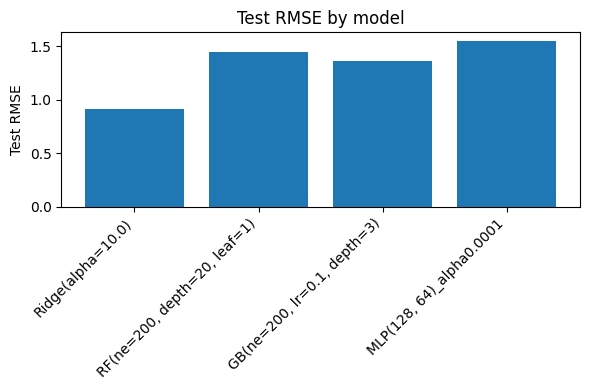

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(range(len(results_df)), results_df["test_rmse"].values)
plt.xticks(range(len(results_df)), results_df["model"].values, rotation=45, ha="right")
plt.ylabel("Test RMSE")
plt.title("Test RMSE by model")
plt.tight_layout()
plt.show()


Section 3 – Sequence models: LSTM & tiny Transformer

3.1 Build sequence dataset

We’ll reuse df, feature_cols, target_cols from before, but now construct sequences of length window.

In [ ]:
import numpy as np

feature_cols = ["p", "q", "r", "ax", "ay", "az", "u1", "u2", "u3", "u4"]
target_cols  = ["p", "q", "r", "ax", "ay", "az"]

def make_sequence_dataset(df, feature_cols, target_cols, window):
    """
    Build (X_seq, y_seq) where:
      X_seq: (N, window, D_in)  -> history [t-window+1 .. t]
      y_seq: (N, D_out)         -> target at time t+1
    """
    feats = df[feature_cols].to_numpy()
    targs = df[target_cols].to_numpy()

    X_seq = []
    Y_seq = []
    # last index we can start: len(df) - window - 1 (because y at +1)
    for i in range(len(df) - window - 1):
        X_seq.append(feats[i : i + window])
        Y_seq.append(targs[i + window + 1])  # next state after the window

    return np.array(X_seq), np.array(Y_seq)

window = 20  # you can try 10, 20, 50 later
X_seq, y_seq = make_sequence_dataset(df, feature_cols, target_cols, window)

print("X_seq shape:", X_seq.shape)  # (N, T, D_in)
print("y_seq shape:", y_seq.shape)  # (N, D_out)


X_seq shape: (27503, 20, 10)
y_seq shape: (27503, 6)


3.2 Time-ordered train/val/test splits

In [ ]:
N_seq = len(X_seq)
n_train_seq = int(0.70 * N_seq)
n_val_seq   = int(0.15 * N_seq)
n_test_seq  = N_seq - n_train_seq - n_val_seq

X_train_seq = X_seq[:n_train_seq]
y_train_seq = y_seq[:n_train_seq]

X_val_seq   = X_seq[n_train_seq:n_train_seq + n_val_seq]
y_val_seq   = y_seq[n_train_seq:n_train_seq + n_val_seq]

X_test_seq  = X_seq[n_train_seq + n_val_seq:]
y_test_seq  = y_seq[n_train_seq + n_val_seq:]

X_train_seq.shape, X_val_seq.shape, X_test_seq.shape


((19252, 20, 10), (4125, 20, 10), (4126, 20, 10))

3.3 LSTM model (Keras)


In [ ]:
import tensorflow as tf

D_in  = X_train_seq.shape[2]
D_out = y_train_seq.shape[1]

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, D_in)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(D_out)  # linear output
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,750 (92.77 KB)

 Trainable params: 23,750 (92.77 KB)

 Non-trainable params: 0 (0.00 B)

Train with early stopping:

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_rmse",
    patience=10,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.3585 - rmse: 1.9309 - val_loss: 0.0624 - val_rmse: 0.2498
Epoch 2/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0335 - rmse: 0.1830 - val_loss: 0.0477 - val_rmse: 0.2185
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0282 - rmse: 0.1678 - val_loss: 0.0456 - val_rmse: 0.2136
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0413 - val_rmse: 0.2031
Epoch 5/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0245 - rmse: 0.1564 - val_loss: 0.0377 - val_rmse: 0.1943
Epoch 6/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0245 - rmse: 0.1565 - val_loss: 0.0362 - val_rmse: 0.1902
Epoch 7/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0219 - rmse: 0.1481 - val_loss: 0.0353 - val_rmse: 0.1878
Epoch 8/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0206 - rmse: 0.1436 - val_loss: 0.0344 - val_rmse: 0.1855
Epoch 9/200
301/301 ━━━━━━━━━━━━

Evaluate on test:

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_seq)

def per_channel_rmse_np(y_true, y_pred, names):
    mse = ((y_true - y_pred)**2).mean(axis=0)
    rmse = np.sqrt(mse)
    for name, r in zip(names, rmse):
        print(f"{name}: RMSE = {r:.4f}")
    return rmse, float(np.sqrt(((y_true - y_pred)**2).mean()))

print("LSTM per-output RMSE on test:")
rmse_lstm_ch, rmse_lstm_overall = per_channel_rmse_np(y_test_seq, y_test_pred_lstm, target_cols)
print("LSTM overall Test RMSE:", rmse_lstm_overall)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM per-output RMSE on test:
p: RMSE = 0.1706
q: RMSE = 0.1435
r: RMSE = 0.1266
ax: RMSE = 2.7498
ay: RMSE = 1.0672
az: RMSE = 2.4990
LSTM overall Test RMSE: 1.5817252397537231


3.4 Tiny Transformer encoder model

Simple encoder-only Transformer for same task.

In [ ]:
D_model  = 64    # internal embedding size
num_heads = 2
ff_dim    = 128  # feedforward layer size

inputs = tf.keras.Input(shape=(window, D_in))

# Linear projection of inputs to model dimension
x = tf.keras.layers.Dense(D_model)(inputs)

# --- Self-attention block ---
attn_output = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads,
    key_dim=D_model
)(x, x)
x = tf.keras.layers.Add()([x, attn_output])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# --- Feed-forward block ---
ff = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
ff = tf.keras.layers.Dense(D_model)(ff)
x = tf.keras.layers.Add()([x, ff])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Pool over time (average)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(D_out)(x)

trans_model = tf.keras.Model(inputs=inputs, outputs=outputs)

trans_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

trans_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 64)    │        704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 64)    │     33,216 │ dense_2[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 64)    │          0 │ dense_2[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 20, 64)    │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 6)         │        390 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,142 (199.77 KB)

 Trainable params: 51,142 (199.77 KB)

 Non-trainable params: 0 (0.00 B)

Train & evaluate:

In [ ]:
history_trans = trans_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

y_test_pred_trans = trans_model.predict(X_test_seq)

print("Transformer per-output RMSE on test:")
rmse_trans_ch, rmse_trans_overall = per_channel_rmse_np(y_test_seq, y_test_pred_trans, target_cols)
print("Transformer overall Test RMSE:", rmse_trans_overall)


Epoch 1/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - loss: 3.6379 - rmse: 1.8044 - val_loss: 0.6173 - val_rmse: 0.7857
Epoch 2/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3296 - rmse: 0.5720 - val_loss: 0.0740 - val_rmse: 0.2721
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1241 - rmse: 0.3514 - val_loss: 0.5116 - val_rmse: 0.7153
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1296 - rmse: 0.3572 - val_loss: 0.0710 - val_rmse: 0.2665
Epoch 5/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0690 - rmse: 0.2622 - val_loss: 0.0595 - val_rmse: 0.2438
Epoch 6/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0469 - rmse: 0.2164 - val_loss: 0.0589 - val_rmse: 0.2427
Epoch 7/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0481 - rmse: 0.2192 - val_loss: 0.0954 - val_rmse: 0.3089
Epoch 8/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0432 - rmse: 0.2076 - val_loss: 0.2448 - val_rmse: 0.4948
Epoch 9/200
301/301 ━━━━━━━━━━

Section 4 – Physics-guided features for attitude (p,q,r only)

Now we focus on attitude dynamics, and build raw vs physics-guided feature sets, both with Ridge.

4.1 Define torque-style features

In [ ]:
# make sure df has u1..u4 already
df["u_thrust"] = df["u1"] + df["u2"] + df["u3"] + df["u4"]
df["u_roll"]   = df["u2"] - df["u4"]
df["u_pitch"]  = df["u3"] - df["u1"]
df["u_yaw"]    = df["u1"] - df["u2"] + df["u3"] - df["u4"]

att_state_cols = ["p", "q", "r"]

# Monolithic variant: use individual motors
feat_mono_cols = ["p", "q", "r", "u1", "u2", "u3", "u4"]

# Physics-guided variant: use thrust/torques
feat_phys_cols = ["p", "q", "r", "u_thrust", "u_roll", "u_pitch", "u_yaw"]

# Target is next-step attitude (p,q,r)
t_all_att = df["t"].values
X_mono_all = df[feat_mono_cols].to_numpy()
X_phys_all = df[feat_phys_cols].to_numpy()
y_att_all  = df[att_state_cols].to_numpy()

# 1-step shift
X_mono = X_mono_all[:-1]
X_phys = X_phys_all[:-1]
y_att  = y_att_all[1:]

t_att_for_X = t_all_att[:-1]

X_mono.shape, X_phys.shape, y_att.shape


((27523, 7), (27523, 7), (27523, 3))

4.2 Time split (same proportions as before)

In [ ]:
N_att = len(X_mono)
n_train_att = int(0.70 * N_att)
n_val_att   = int(0.15 * N_att)
n_test_att  = N_att - n_train_att - n_val_att

def split_att(X_full, y_full):
    X_tr = X_full[:n_train_att]
    y_tr = y_full[:n_train_att]
    X_va = X_full[n_train_att:n_train_att + n_val_att]
    y_va = y_full[n_train_att:n_train_att + n_val_att]
    X_te = X_full[n_train_att + n_val_att:]
    y_te = y_full[n_train_att + n_val_att:]
    return X_tr, y_tr, X_va, y_va, X_te, y_te

X_mono_tr, y_att_tr, X_mono_va, y_att_va, X_mono_te, y_att_te = split_att(X_mono, y_att)
X_phys_tr, y_att_tr2, X_phys_va, y_att_va2, X_phys_te, y_att_te2 = split_att(X_phys, y_att)

# sanity check: same targets
assert np.allclose(y_att_tr, y_att_tr2)
assert np.allclose(y_att_va, y_att_va2)
assert np.allclose(y_att_te, y_att_te2)

X_mono_tr.shape, X_phys_tr.shape


((19266, 7), (19266, 7))

4.3 Ridge on monolithic vs physics-guided features

We reuse the evaluation helper.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

alphas_att = [1e-3, 1e-2, 1e-1, 1.0, 10.0]

def tune_ridge_for_features(Xtr, ytr, Xva, yva, Xte, yte, feature_set_name):
    best = None
    results = []
    for a in alphas_att:
        model = make_pipeline(
            StandardScaler(),
            Ridge(alpha=a)
        )
        name = f"Ridge_{feature_set_name}_alpha={a}"
        res  = eval_model(name, model,
                          Xtr, ytr,
                          Xva, yva,
                          Xte, yte,
                          att_state_cols)
        res["alpha"] = a
        res["feature_set"] = feature_set_name
        results.append(res)
        if (best is None) or (res["val_rmse"] < best["val_rmse"]):
            best = res
    return best, results

best_mono, mono_results = tune_ridge_for_features(
    X_mono_tr, y_att_tr,
    X_mono_va, y_att_va,
    X_mono_te, y_att_te,
    feature_set_name="mono"
)

best_phys, phys_results = tune_ridge_for_features(
    X_phys_tr, y_att_tr,
    X_phys_va, y_att_va,
    X_phys_te, y_att_te,
    feature_set_name="phys"
)

best_mono, best_phys



=== Ridge_mono_alpha=0.001 ===
Val RMSE : 0.013555723585806466
Test RMSE: 0.03873523923962685
    p: Val RMSE = 0.0114, Test RMSE = 0.0316
    q: Val RMSE = 0.0187, Test RMSE = 0.0503
    r: Val RMSE = 0.0085, Test RMSE = 0.0311

=== Ridge_mono_alpha=0.01 ===
Val RMSE : 0.013555713924405296
Test RMSE: 0.03873519866655441
    p: Val RMSE = 0.0114, Test RMSE = 0.0316
    q: Val RMSE = 0.0187, Test RMSE = 0.0503
    r: Val RMSE = 0.0085, Test RMSE = 0.0311

=== Ridge_mono_alpha=0.1 ===
Val RMSE : 0.013555652198624172
Test RMSE: 0.03873488009132352
    p: Val RMSE = 0.0114, Test RMSE = 0.0316
    q: Val RMSE = 0.0187, Test RMSE = 0.0503
    r: Val RMSE = 0.0085, Test RMSE = 0.0311

=== Ridge_mono_alpha=1.0 ===
Val RMSE : 0.013555119198230704
Test RMSE: 0.038731622058358076
    p: Val RMSE = 0.0114, Test RMSE = 0.0316
    q: Val RMSE = 0.0187, Test RMSE = 0.0503
    r: Val RMSE = 0.0085, Test RMSE = 0.0311

=== Ridge_mono_alpha=10.0 ===
Val RMSE : 0.013550209026489736
Test RMSE: 0.03869961

({'model': 'Ridge_mono_alpha=10.0',
  'val_rmse': np.float64(0.013550209026489736),
  'test_rmse': np.float64(0.03869961625004101),
  'val_p': np.float32(0.011364486),
  'test_p': np.float32(0.031573053),
  'val_q': np.float32(0.018710498),
  'test_q': np.float32(0.050284576),
  'val_r': np.float32(0.008461101),
  'test_r': np.float32(0.031106025),
  'alpha': 10.0,
  'feature_set': 'mono'},
 {'model': 'Ridge_phys_alpha=10.0',
  'val_rmse': np.float64(0.013551338212120942),
  'test_rmse': np.float64(0.03870841717719506),
  'val_p': np.float32(0.011366646),
  'test_p': np.float32(0.03158048),
  'val_q': np.float32(0.018711727),
  'test_q': np.float32(0.05030011),
  'val_r': np.float32(0.0084609045),
  'test_r': np.float32(0.031106217),
  'alpha': 10.0,
  'feature_set': 'phys'})

4.4 Compare best monolithic vs best physics-guided in a small table

In [ ]:
att_results_df = pd.DataFrame([best_mono, best_phys])

use_cols = ["model", "feature_set", "val_rmse", "test_rmse"] \
           + [f"val_{c}" for c in att_state_cols] \
           + [f"test_{c}" for c in att_state_cols] \
           + ["alpha"]

att_results_df = att_results_df[use_cols]
att_results_df


,model,feature_set,val_rmse,test_rmse,val_p,val_q,val_r,test_p,test_q,test_r,alpha
0,Ridge_mono_alpha=10.0,mono,0.013550,0.038700,0.011364,0.018710,0.008461,0.031573,0.050285,0.031106,10.0
1,Ridge_phys_alpha=10.0,phys,0.013551,0.038708,0.011367,0.018712,0.008461,0.031580,0.050300,0.031106,10.0


We can also visualize one time-series (e.g. p) for both models:

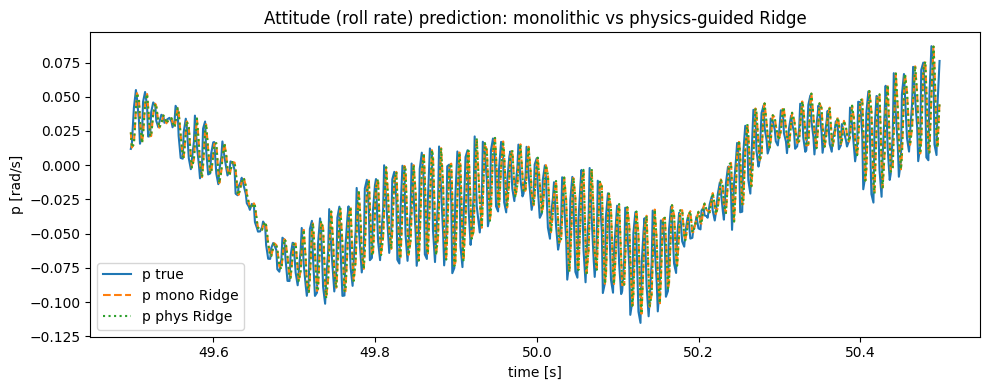

In [ ]:
# Refit the best two models so we can get predictions for plotting
def build_ridge_pipeline(alpha):
    return make_pipeline(
        StandardScaler(),
        Ridge(alpha=alpha)
    )

ridge_mono_final = build_ridge_pipeline(best_mono["alpha"])
ridge_mono_final.fit(
    np.vstack([X_mono_tr, X_mono_va]),
    np.vstack([y_att_tr, y_att_va])
)

ridge_phys_final = build_ridge_pipeline(best_phys["alpha"])
ridge_phys_final.fit(
    np.vstack([X_phys_tr, X_phys_va]),
    np.vstack([y_att_tr, y_att_va])
)

y_mono_pred = ridge_mono_final.predict(X_mono_te)
y_phys_pred = ridge_phys_final.predict(X_phys_te)

t_att_test = t_att_for_X[n_train_att + n_val_att:]

# plot a short window for clarity
start = 1000
length = 500
end = start + length

plt.figure(figsize=(10,4))
plt.plot(t_att_test[start:end], y_att_te[start:end, 0], label="p true")
plt.plot(t_att_test[start:end], y_mono_pred[start:end, 0], "--", label="p mono Ridge")
plt.plot(t_att_test[start:end], y_phys_pred[start:end, 0], ":", label="p phys Ridge")
plt.xlabel("time [s]")
plt.ylabel("p [rad/s]")
plt.title("Attitude (roll rate) prediction: monolithic vs physics-guided Ridge")
plt.legend()
plt.tight_layout()
plt.show()


4.5 inspect unscaled physics-guided coefficients for interpretability

For interpretation only, you can fit a Ridge without scaling on train+val and look at coefficients:

In [ ]:
X_phys_trval = np.vstack([X_phys_tr, X_phys_va])
y_att_trval  = np.vstack([y_att_tr, y_att_va])

ridge_phys_unscaled = Ridge(alpha=best_phys["alpha"])
ridge_phys_unscaled.fit(X_phys_trval, y_att_trval)

coef_matrix = ridge_phys_unscaled.coef_  # shape (3 outputs, 7 inputs)
coef_df = pd.DataFrame(coef_matrix,
                       index=[f"{c}_next" for c in att_state_cols],
                       columns=feat_phys_cols)
coef_df


,p,q,r,u_thrust,u_roll,u_pitch,u_yaw
p_next,0.996013,0.001413,-0.000625,-0.000269,0.025029,0.019701,-0.007684
q_next,-0.001441,0.988525,0.000579,0.000333,0.002653,0.007822,0.016874
r_next,-0.001234,0.001693,0.964127,-0.000026,-0.002060,-0.006834,0.009712


Section 5 – Flight regimes, per-regime performance & bootstrap uncertainty
5.1 Add thrust feature & build clustering features

In [ ]:

df["u_thrust"] = df["u1"] + df["u2"] + df["u3"] + df["u4"]

cluster_feature_cols = ["p", "q", "r", "ax", "ay", "az", "u_thrust"]
Z = df[cluster_feature_cols].to_numpy()
Z.shape


(27524, 7)

Standardize & run K-means:

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler_cluster = StandardScaler()
Z_scaled = scaler_cluster.fit_transform(Z)

K = 3  # you can experiment with 2, 3, 4
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(Z_scaled)

df["cluster"] = cluster_labels
df["cluster"].value_counts()


,count
cluster,
0,17236
1,10173
2,115


Quick summary of each cluster:

In [ ]:
summary = df.groupby("cluster")[cluster_feature_cols].agg(["mean", "std"])
summary


p                   q                   r                  ax  \
             mean       std      mean       std      mean       std      mean   
cluster                                                                         
0       -0.006904  0.141604  0.009818  0.177633 -0.020534  0.096315 -0.134106   
1        0.040401  0.220200 -0.016212  0.210608  0.049780  0.119792  0.065887   
2       -2.455703  0.894354  0.075977  0.348727  0.192496  0.085285 -0.170873   

                         ay                   az            u_thrust            
              std      mean       std       mean       std      mean       std  
cluster                                                                         
0        1.032997 -0.094613  0.379498 -11.109104  3.594275  1.880075  0.397834  
1        1.392061  0.089216  0.567801  -7.646195  2.899233  0.841821  0.486984  
2        2.339020 -1.606580  3.663947  -5.563446  4.684771  1.072518  0.204896

5.2 Visualize clusters in time and in p–q space

p(t) colored by cluster:

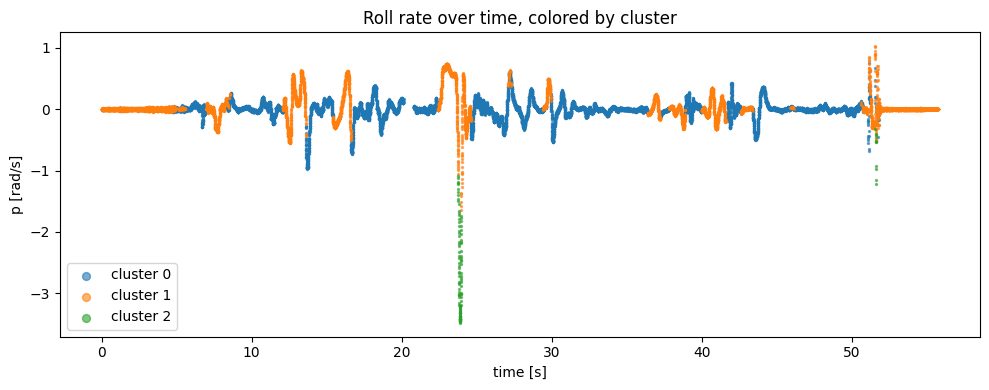

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
for c in range(K):
    mask = df["cluster"] == c
    plt.scatter(df.loc[mask, "t"],
                df.loc[mask, "p"],
                s=2,
                alpha=0.6,
                label=f"cluster {c}")
plt.xlabel("time [s]")
plt.ylabel("p [rad/s]")
plt.title("Roll rate over time, colored by cluster")
plt.legend(markerscale=4)
plt.tight_layout()
plt.show()


Phase plot p–q colored by cluster:

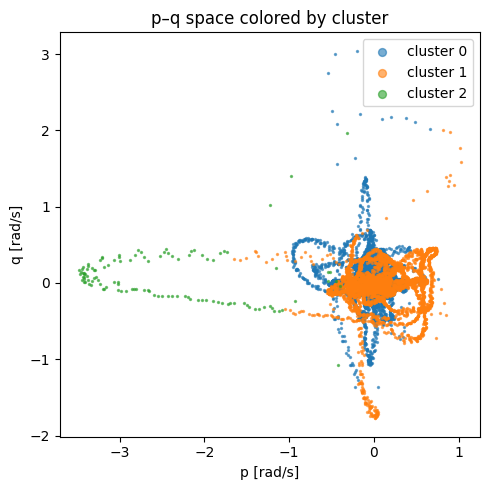

In [ ]:
plt.figure(figsize=(5,5))
for c in range(K):
    mask = df["cluster"] == c
    plt.scatter(df.loc[mask, "p"],
                df.loc[mask, "q"],
                s=2,
                alpha=0.6,
                label=f"cluster {c}")
plt.xlabel("p [rad/s]")
plt.ylabel("q [rad/s]")
plt.title("p–q space colored by cluster")
plt.legend(markerscale=4)
plt.tight_layout()
plt.show()


5.3 Align clusters with X_train / X_val / X_test

In [ ]:
# We built X,y from df[:-1] -> df[1:], so use df.iloc[:-1]
cluster_for_X = df["cluster"].iloc[:-1].to_numpy()
len(cluster_for_X), len(X_train) + len(X_val) + len(X_test)


(27523, 27523)

Split into train / val / test, matching earlier splits:

In [ ]:
cluster_train = cluster_for_X[:n_train]
cluster_val   = cluster_for_X[n_train:n_train + n_val]
cluster_test  = cluster_for_X[n_train + n_val:]


For per-cluster evaluation we’ll train on train+val and test on test:

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.vstack([y_train, y_val])
cluster_train_full = np.concatenate([cluster_train, cluster_val])

X_train_full.shape, y_train_full.shape, cluster_test.shape


((23394, 16), (23394, 12), (4129,))

5.4 Per-cluster RMSE: Ridge & Gradient Boosting

Rebuild best Ridge and GB models from your tuned dicts:

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Build best Ridge
ridge_alpha = float(best_ridge["alpha"])
ridge_model = make_pipeline(
    StandardScaler(),
    Ridge(alpha=ridge_alpha)
)

# Build best Gradient Boosting (multi-output)
gb_ne    = int(best_gb["n_estimators"])
gb_lr    = float(best_gb["learning_rate"])
gb_depth = int(best_gb["max_depth"])

gb_base = GradientBoostingRegressor(
    n_estimators=gb_ne,
    learning_rate=gb_lr,
    max_depth=gb_depth,
    random_state=0,
)
gb_model = MultiOutputRegressor(gb_base)


Helper for per-cluster RMSE:

In [ ]:
def per_cluster_rmse(name, model,
                     X_train_full, y_train_full,
                     X_test, y_test,
                     cluster_test, target_cols):
    model.fit(X_train_full, y_train_full)
    y_pred = model.predict(X_test)

    print(f"\n=== {name}: per-cluster RMSE on test ===")
    for c in np.unique(cluster_test):
        mask = (cluster_test == c)
        if mask.sum() == 0:
            continue
        rmse_overall = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
        mse_ch = ((y_test[mask] - y_pred[mask])**2).mean(axis=0)
        rmse_ch = np.sqrt(mse_ch)
        print(f"\nCluster {int(c)} (n={mask.sum()}): overall RMSE = {rmse_overall:.4f}")
        for col, r in zip(target_cols, rmse_ch):
            print(f"  {col}: RMSE = {r:.4f}")


Run it for Ridge and GB:

In [ ]:
per_cluster_rmse("Ridge", ridge_model,
                 X_train_full, y_train_full,
                 X_test, y_test,
                 cluster_test, target_cols)

per_cluster_rmse("Gradient Boosting", gb_model,
                 X_train_full, y_train_full,
                 X_test, y_test,
                 cluster_test, target_cols)



=== Ridge: per-cluster RMSE on test ===

Cluster 0 (n=1707): overall RMSE = 1.0827
  p: RMSE = 0.0337
  q: RMSE = 0.0337
  r: RMSE = 0.0685
  ax: RMSE = 0.0685
  ay: RMSE = 0.0332
  az: RMSE = 0.0332

Cluster 1 (n=2411): overall RMSE = 0.7392
  p: RMSE = 0.0264
  q: RMSE = 0.0264
  r: RMSE = 0.0258
  ax: RMSE = 0.0258
  ay: RMSE = 0.0304
  az: RMSE = 0.0304

Cluster 2 (n=11): overall RMSE = 3.8317
  p: RMSE = 0.3217
  q: RMSE = 0.3217
  r: RMSE = 0.4651
  ax: RMSE = 0.4651
  ay: RMSE = 0.1699
  az: RMSE = 0.1699

=== Gradient Boosting: per-cluster RMSE on test ===

Cluster 0 (n=1707): overall RMSE = 1.5450
  p: RMSE = 0.0313
  q: RMSE = 0.0313
  r: RMSE = 0.1014
  ax: RMSE = 0.1014
  ay: RMSE = 0.0302
  az: RMSE = 0.0302

Cluster 1 (n=2411): overall RMSE = 1.1785
  p: RMSE = 0.0263
  q: RMSE = 0.0263
  r: RMSE = 0.0359
  ax: RMSE = 0.0359
  ay: RMSE = 0.0416
  az: RMSE = 0.0416

Cluster 2 (n=11): overall RMSE = 5.7046
  p: RMSE = 0.2826
  q: RMSE = 0.2826
  r: RMSE = 0.4220
  ax: RMSE

5.5 Bootstrap ensemble for Ridge → predictive uncertainty

Now we estimate uncertainty of Ridge by bootstrapping the training set.

In [ ]:
B = 50  # number of bootstrap models (20–50 is fine)
n_train_full = X_train_full.shape[0]
n_test = X_test.shape[0]
n_targets = y_test.shape[1]

boot_preds = np.zeros((B, n_test, n_targets))
rng = np.random.default_rng(seed=0)

for b in range(B):
    idx = rng.integers(low=0, high=n_train_full, size=n_train_full)
    X_boot = X_train_full[idx]
    y_boot = y_train_full[idx]

    model_b = make_pipeline(
        StandardScaler(),
        Ridge(alpha=ridge_alpha)
    )
    model_b.fit(X_boot, y_boot)
    boot_preds[b] = model_b.predict(X_test)

# Ensemble statistics
y_pred_mean = boot_preds.mean(axis=0)
y_pred_std  = boot_preds.std(axis=0)

rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_mean))
print("Bootstrap ensemble mean Test RMSE:", rmse_ensemble)


Bootstrap ensemble mean Test RMSE: 0.9181900409048162


5.6 Visualize ±2σ uncertainty band for roll rate p(t)

We’ll plot on a window of the test segment.

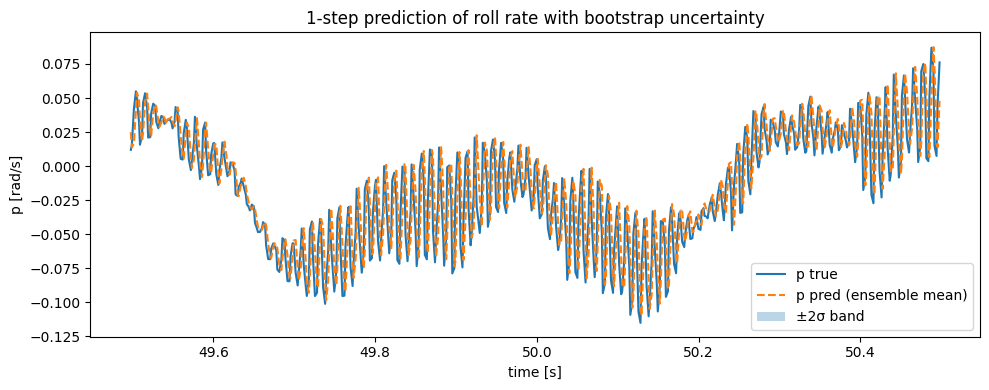

In [ ]:
# time stamps for X_test
t_test = t_for_X[n_train + n_val:]

axis_idx = 0  # 0=p, 1=q, 2=r, etc.
start = 1000  # starting index within test set (tune for nice window)
length = 500
end = start + length

t_slice      = t_test[start:end]
y_true_slice = y_test[start:end, axis_idx]
y_mean_slice = y_pred_mean[start:end, axis_idx]
y_std_slice  = y_pred_std[start:end, axis_idx]

upper = y_mean_slice + 2*y_std_slice
lower = y_mean_slice - 2*y_std_slice

plt.figure(figsize=(10,4))
plt.plot(t_slice, y_true_slice, label="p true")
plt.plot(t_slice, y_mean_slice, "--", label="p pred (ensemble mean)")
plt.fill_between(t_slice, lower, upper, alpha=0.3, label="±2σ band")

plt.xlabel("time [s]")
plt.ylabel("p [rad/s]")
plt.title("1-step prediction of roll rate with bootstrap uncertainty")
plt.legend()
plt.tight_layout()
plt.show()


5.7 Mean uncertainty per cluster

Now connect uncertainty to regimes: hover vs aggressive.

In [ ]:
axis_idx = 0  # focus on roll rate p, but you can loop over axes

print("Mean predictive std for p per cluster (test set):")
for c in np.unique(cluster_test):
    mask = (cluster_test == c)
    if mask.sum() == 0:
        continue
    avg_std = y_pred_std[mask, axis_idx].mean()
    print(f"  Cluster {int(c)} (n={mask.sum()}): mean std = {avg_std:.5f}")


Mean predictive std for p per cluster (test set):
  Cluster 0 (n=1707): mean std = 0.00045
  Cluster 1 (n=2411): mean std = 0.00055
  Cluster 2 (n=11): mean std = 0.00599


Section 6 – Extract roll-axis linear model from physics-guided dynamics
6.1 Identify the “hover” cluster systematically

We’ll pick the cluster whose angular rates are smallest on average (most hover-like).

In [ ]:
import numpy as np
import pandas as pd

# Compute an angular activity metric per cluster: RMS of [p,q,r]
cluster_ids = sorted(df["cluster"].unique())

cluster_rms = {}
for c in cluster_ids:
    sub = df[df["cluster"] == c]
    rms = np.sqrt((sub["p"]**2 + sub["q"]**2 + sub["r"]**2).mean())
    cluster_rms[c] = rms

cluster_rms


{np.int32(0): np.float32(0.24787825),
 np.int32(1): np.float32(0.3340004),
 np.int32(2): np.float32(2.6446137)}

Pick the cluster with smallest RMS:

In [ ]:
hover_cluster = min(cluster_rms, key=cluster_rms.get)
hover_cluster


np.int32(0)

6.2 Build hover-only subset for roll dynamics

Recall:

X_phys has features [p, q, r, u_thrust, u_roll, u_pitch, u_yaw] at time
𝑡.

y_att has [p_next, q_next, r_next] at time
𝑡
+
1.

cluster_for_X has the cluster label for the same index as X_phys[i].

Let’s pull out only samples in the hover cluster:

In [ ]:
# mask of samples in hover cluster for the (X,y) pairs
hover_mask = (cluster_for_X == hover_cluster)

X_phys_hover = X_phys[hover_mask]
y_att_hover  = y_att[hover_mask]
t_hover      = t_att_for_X[hover_mask]

X_phys_hover.shape, y_att_hover.shape, t_hover.shape


((17236, 7), (17236, 3), (17236,))

Check how many hover samples you have:

In [ ]:
print("Hover cluster:", hover_cluster)
print("Number of hover samples used for roll model:", len(X_phys_hover))


Hover cluster: 0
Number of hover samples used for roll model: 17236


6.3 Fit a 1D roll-rate ARX model:


We’ll use unregularized LinearRegression here for interpretability (Ridge in earlier sections was for prediction robustness).

In [ ]:
from sklearn.linear_model import LinearRegression

# indices for convenience
i_p       = feat_phys_cols.index("p")
i_u_roll  = feat_phys_cols.index("u_roll")
i_p_next  = att_state_cols.index("p")

p_t_hover      = X_phys_hover[:, i_p]
u_roll_t_hover = X_phys_hover[:, i_u_roll]
p_next_hover   = y_att_hover[:, i_p_next]

# Design matrix: [p_t, u_roll_t]
X_roll_hover = np.column_stack([p_t_hover, u_roll_t_hover])
y_roll_hover = p_next_hover

roll_reg = LinearRegression()
roll_reg.fit(X_roll_hover, y_roll_hover)

a_p = roll_reg.coef_[0]
b_p = roll_reg.coef_[1]
c_p = roll_reg.intercept_

print("Roll model parameters (discrete-time):")
print(f"  p_next = a * p + b * u_roll + c")
print(f"  a = {a_p:.6f}")
print(f"  b = {b_p:.6f}")
print(f"  c = {c_p:.6f}")


Roll model parameters (discrete-time):
  p_next = a * p + b * u_roll + c
  a = 0.993698
  b = 0.006609
  c = -0.000126


Check how good this simple model is on the hover subset:

In [ ]:
from sklearn.metrics import mean_squared_error

p_pred_hover = roll_reg.predict(X_roll_hover)
rmse_hover_roll = np.sqrt(mean_squared_error(p_next_hover, p_pred_hover))
print("Hover-subset RMSE for roll model (p_next):", rmse_hover_roll)


Hover-subset RMSE for roll model (p_next): 0.01579126543615339


6.4 Extract A, B, b and an effective Δt for MATLAB

We can treat this as a 1D linear, discrete-time system:

In [ ]:
# A, B, b in discrete time
A_roll = np.array([[a_p]])
B_roll = np.array([[b_p]])
b_roll = np.array([[c_p]])

print("A_roll:", A_roll)
print("B_roll:", B_roll)
print("b_roll:", b_roll)

# approximate dt in hover regime (mean dt)
dt_hover = np.diff(t_hover)
dt_mean_hover = dt_hover.mean()
dt_std_hover  = dt_hover.std()
print(f"Approximate dt in hover regime: mean = {dt_mean_hover:.4f} s, std = {dt_std_hover:.4f} s")


A_roll: [[0.9936976]]
B_roll: [[0.00660908]]
b_roll: [[-0.00012585]]
Approximate dt in hover regime: mean = 0.0028 s, std = 0.0284 s


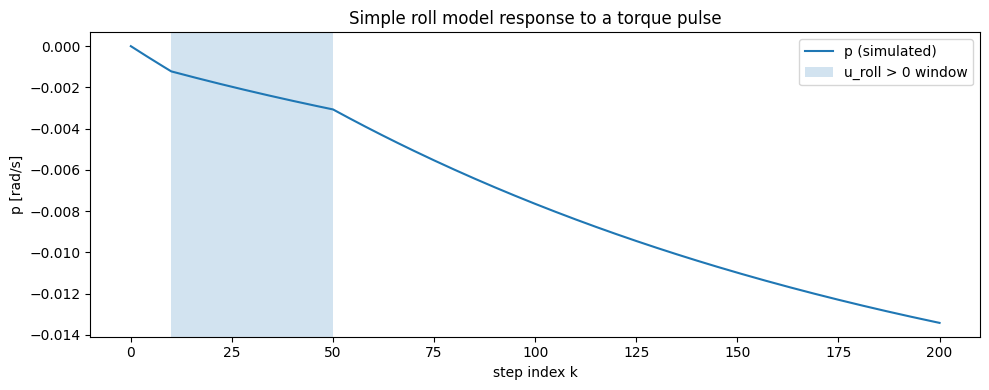

In [ ]:
def simulate_roll_model(p0, u_seq, A, B, b):
    """
    Simulate discrete roll model for a given control sequence.
    p0: initial roll rate
    u_seq: array of u_roll commands (length T)
    returns: array of p values of length T+1
    """
    p_vals = [p0]
    p = p0
    for u in u_seq:
        p_next = (A[0,0] * p) + (B[0,0] * u) + b[0,0]
        p_vals.append(p_next)
        p = p_next
    return np.array(p_vals)

# Example: step input in hover regime
T_sim = 200
u_example = np.zeros(T_sim)
u_example[10:50] = 0.01  # small positive torque for a while

p_sim = simulate_roll_model(p0=0.0, u_seq=u_example, A=A_roll, B=B_roll, b=b_roll)

plt.figure(figsize=(10,4))
plt.plot(p_sim, label="p (simulated)")
plt.axvspan(10, 50, alpha=0.2, label="u_roll > 0 window")
plt.xlabel("step index k")
plt.ylabel("p [rad/s]")
plt.title("Simple roll model response to a torque pulse")
plt.legend()
plt.tight_layout()
plt.show()
